# Назначение — Распространение и эпидемии в сетях

In [24]:
import networkx as nx
from tqdm.notebook import trange
import numpy as np
from matplotlib.animation import FuncAnimation
from scipy.optimize import minimize
from IPython.display import HTML
from zlib import adler32
import matplotlib.pyplot as plt

Task 1. Euler method (0 points)

Метод Эйлера - это простая численная процедура для решения обыкновенных дифференциальных уравнений (ОДУ) с заданными начальными значениями. Например, если мы хотим решить уравнение
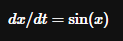
с начальным значением  мы можем выделить  следовательно, мы получаем 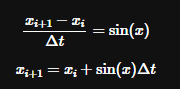 
Позвольте , и тогда мы можем решить уравнение, используя эту итеративную форму следующим образом

In [25]:
def solve_sinx(x0, dt, k):
    x = x0
    solution = [x0]
    for _ in range(k):
        dx = np.sin(x) * dt
        x = x + dx
        solution.append(x)
    return solution

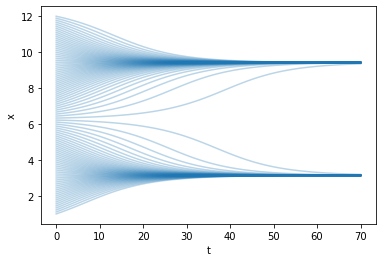

In [26]:
dt = 0.1
for x0 in np.linspace(1, 12, 100):
    solution = solve_sinx(x0, dt, 70)
    plt.plot(solution, c='tab:blue', alpha=0.3);
plt.xlabel('t')
plt.ylabel('x')
plt.show()

Предположим, что мы хотим решить знаменитую хаотическую систему Лоренца:
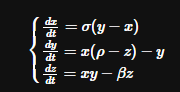
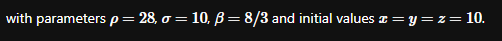
Напишите функцию lorenz, которая принимает начальные значения, параметры, приращение времени dt, количество итераций k и возвращает np.массив с решением вида [[x0, y0, z0], [x1, y1, z1], ...] так, чтобы количество строк было k+1.

In [27]:
def lorenz(x0, y0, z0, rho, sigma, beta, dt, k):
    # YOUR CODE HERE
    res = np.zeros((k+1, 3)) # np.zeros - Возвращает новый массив заданной формы и типа, заполненный нулями.
    res[0][0] = x0
    res[0][1] = y0
    res[0][2] = z0
    for i in range(1, k):
        x = res[i-1][0]
        y = res[i-1][1]
        z = res[i-1][2]
        res[i][0] = x + (sigma*(y-x))*dt 
        res[i][1] = y + (x*(rho-z)-y)*dt
        res[i][2] = z + (x*y - beta*z)*dt
    return res

In [28]:
sim = lorenz(10., 10., 10., 28., 10., 8/3, 0.01, 8000-1)
assert sim.shape == (8000, 3)
assert np.all(sim[0] == [10, 10, 10])
assert np.all(sim[1].round(2) == [10., 11.7, 10.73])
assert np.all(sim[2].round(2) == [10.17, 13.31, 11.62])
assert adler32(str(sim[3].round(2)[0]).encode()) == 48496892

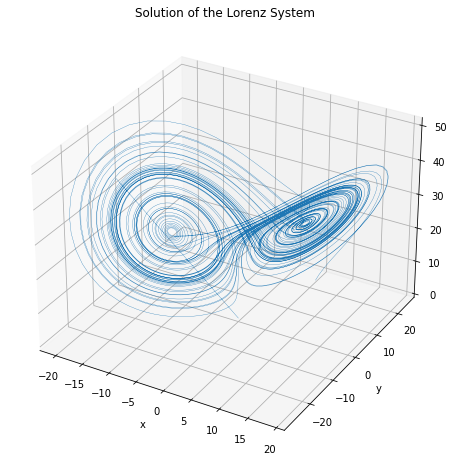

In [29]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')
xs, ys, zs = sim[:, 0], sim[:, 1], sim[:, 2]
ax.plot(xs, ys, zs, lw=0.3)
plt.title('Solution of the Lorenz System')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

Task 2. SI model (0 points)

Рассмотрим простую модель эпидемии — модель SI. S — восприимчивый, I — заразный. Первоначально у нас есть только несколько инфицированных людей, а все остальные восприимчивы. Затем некоторые восприимчивые люди заражаются с высокой скоростью заражения. Модель определяется следующим образом:

Динамическая форма 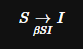
Форма уравнения 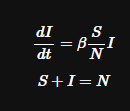 где N - общая численность населения.

Напишите функцию si_epidemic, которая принимает общее количество населения, количество инфицированных людей I0, коэффициент заражения бета, приращение времени dt, количество итераций k и возвращает возвращает np.array с решением вида [[S0, I0], [S1, I1], ...] так, чтобы количество строк равно k+1.

In [30]:
def si_epidemic(total, I0, beta, dt, k):
    # YOUR CODE HERE
    res = np.zeros((k+1, 2)) # np.zeros - Возвращает новый массив заданной формы и типа, заполненный нулями.
    S0 = total - I0
    res[0][0] = S0
    res[0][1] = I0
    
    for i in range(1, k+1):
        S = res[i-1][0]
        I = res[i-1][1]
        res[i][1] = I + beta*(S/total)*I*dt
        res[i][0] = total - res[i][1]
    return res

In [31]:
solution = si_epidemic(total=1000, I0=1, beta=0.3, dt=0.5, k=130-1)
assert solution.shape == (130, 2)
assert np.all(solution[0] == [999, 1])
assert np.all(solution[10].round(2) == [995.97, 4.03])
assert np.all(solution[-1].round(2) == [0, 1000])
assert adler32(str(solution[100].round(2)[0]).encode()) == 32047304

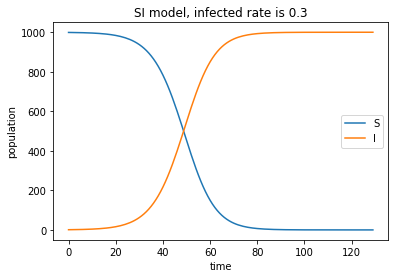

In [32]:
plt.plot(solution)
plt.legend(['S', 'I'])
plt.title('SI model, infected rate is 0.3')
plt.xlabel('time')
plt.ylabel('population')
plt.show()

Давайте посмотрим на график динамики эпидемии с той же настройкой, но 

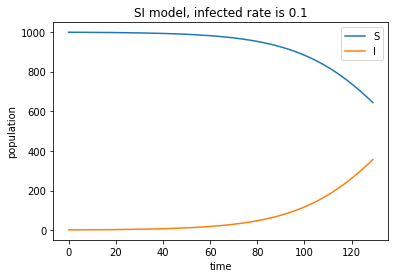

In [33]:
solution = si_epidemic(total=1000, I0=1, beta=0.1, dt=0.5, k=130-1)
plt.plot(solution)
plt.legend(['S', 'I'])
plt.title('SI model, infected rate is 0.1')
plt.xlabel('time')
plt.ylabel('population')
plt.show()

Task 3. SIR model (2 points)

Следующая модель - SIR. S — восприимчивые, I — заразные, R — выздоровевшие люди. Первоначально у нас есть только несколько инфицированных людей, а другие восприимчивы. Затем некоторые восприимчивые люди заражаются с высокой скоростью заражения, а некоторые инфицированные люди выздоравливают с высокой скоростью выздоровления. Нет никаких шансов заразить после выздоровления. Модель определяется следующим образом:

Динамическая форма 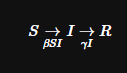
Форма уравнения (в пропорциях к населению) 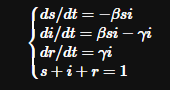

Напишите функцию sir_epidemic, которая принимает начальную пропорцию s0, i0, r0, коэффициент заражения бета, коэффициент выздоровления гамма, количество шагов k и приращение времени dt. Функция возвращает np.массив формы (k+1, 3) с пропорцией s, i, r на каждом шаге. Первая строка содержит начальную пропорцию.

In [34]:
def sir_epidemic(s0, i0, r0, beta, gamma, k, dt):
    # YOUR CODE HERE
    res = np.zeros((k+1, 3)) # np.zeros - Возвращает новый массив заданной формы и типа, заполненный нулями.
    res[0][0] = s0
    res[0][1] = i0
    res[0][2] = r0
    for j in range(1, k+1):
        s = res[j-1][0]
        i = res[j-1][1]
        r = res[j-1][2]
        res[j][0] = s + (-1*beta*s*i)*dt 
        res[j][1] = i + (beta*s*i-gamma*i)*dt
        res[j][2] = r + (gamma*i)*dt
    return res

In [35]:
s0, i0, r0 = 0.99, 0.01, 0
beta, gamma = 0.6, 0.1
dt = 1
epidemic = sir_epidemic(s0, i0, r0, beta, gamma, 80, dt)
assert epidemic.shape == (81, 3)
assert np.all(epidemic[0] == [0.99, 0.01, 0.  ])
assert np.all(epidemic[5].round(2) == [0.92, 0.07, 0.01])
assert np.all(epidemic[80].round(2) == [0, 0, 1])
assert adler32(str(epidemic[10].round(2)[1]).encode()) == 32112840

Здесь также находится критическая точка для базового числа воспроизведения 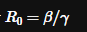

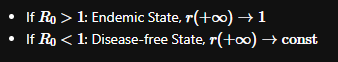
где r(t) - доля выздоровевших людей на данный момент времени t.

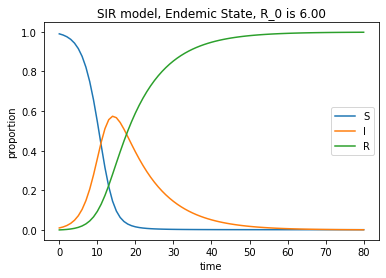

In [36]:
plt.plot(epidemic)
plt.legend(['S', 'I', 'R']);
plt.title('SIR model, Endemic State, R_0 is {:.2f}'.format(beta/gamma))
plt.xlabel('time')
plt.ylabel('proportion')
plt.show()

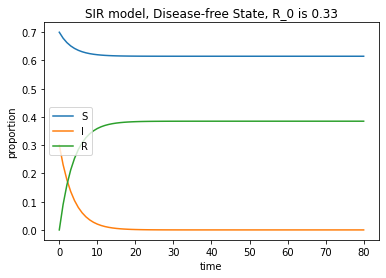

In [37]:
s0, i0, r0 = 0.7, 0.3, 0.
dt = 1
beta, gamma = 0.1, 0.3
epidemic = sir_epidemic(s0, i0, r0, beta, gamma, 80, dt)
plt.plot(epidemic)
plt.legend(['S', 'I', 'R']);
plt.title('SIR model, Disease-free State, R_0 is {:.2f}'.format(beta/gamma))
plt.xlabel('time')
plt.ylabel('proportion')
plt.show()

Задание 4. Диффузии в сетях (2 points)

Диффузионный процесс - это модель распространения, в которой значения узла  распространяются за пределы зоны высокой концентрации. Рассмотрим диффузию на сетке размером 20х20. Пусть существует подсеть 3х3 с теплотворной способностью 3 и подсетка 7х5 с теплотворной способностью 1. Все остальные узлы имеют значение 0. Начальные значения тепла таковы 

In [38]:
phi_map = np.zeros((20, 20))
phi_map[1:4, 1:4] = 3
phi_map[10:15, 8:15] = 1
phi0 = phi_map.flatten()

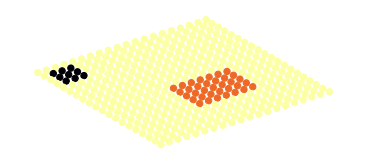

In [39]:
plt.figure(figsize=(7*0.7, 3*0.7))
gridG = nx.grid_graph((20, 20))
nx.draw_kamada_kawai(
    gridG,
    cmap=plt.cm.inferno_r,
    vmin=0, vmax=3,
    width=0,
    node_size=40,
    node_color=phi0)

Создайте моделирование диффузии на основе этого уравнения диффузии 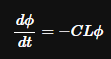
где L - граф Лапласиан.

Напишите функцию next_phi, которая принимает матрицу смежности A, np.массив с предыдущими значениями температуры phi, константой C и приращением времени dt. Функция возвращает np.array со следующими значениями тепла.

In [40]:
def next_phi(A, phi, C, dt):
    # YOUR CODE HERE
    D = np.diag(A.sum(axis=1)) #Функция diag() позволяет извлекать диагональ из массива, 
                               #а так же строить диагональные массивы из одномерных массивов.
    L = D - A
    return (phi - C * L @ phi * dt)

In [41]:
A = nx.to_numpy_array(gridG)
C = 0.1
dt = 2
phi = next_phi(A, phi0, C, dt)
assert phi.shape == (400,)
assert phi.sum() == phi0.sum()
assert phi.std() < phi0.sum()
assert round(phi[20:25].sum(), 4) == 7.2

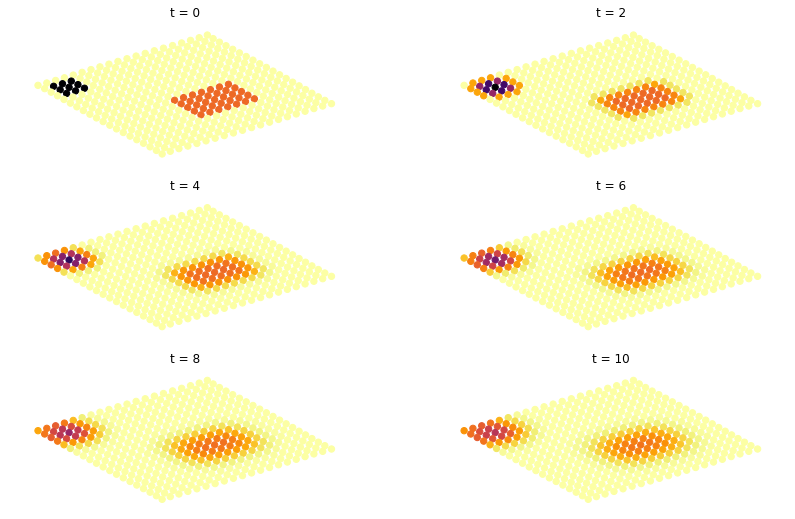

In [42]:
plt.figure(figsize=(7*2, 3*3))

phi = phi0
for i in range(6):
    plt.subplot(3, 2, i+1)
    gridG = nx.grid_graph((20, 20))
    nx.draw_kamada_kawai(
        gridG,
        cmap=plt.cm.inferno_r,
        vmin=0, vmax=3,
        width=0,
        node_size=40,
        node_color=phi)
    plt.title('t = {}'.format(i*dt))
    phi = next_phi(A, phi, C, dt)
phi12 = phi

Мы можем выполнять моделирование шаг за шагом столько, сколько нам нужно, но, к счастью, есть аналитическое решение 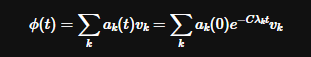
где 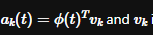 - k-й наименьший собственный вектор лапласиана.

Напишите функцию phi_t, которая принимает матрицу смежности A, np.массив с начальными значениями теплоты phi0, константой C и моментом времени t. Функция возвращает np.массив со значениями тепла в момент времени t. Используйте np.linalg.eigh или scipy.linalg.eigh для симметричной матрицы.

In [43]:
def phi_t(A, phi0, C, t):
    # YOUR CODE HERE
    D = np.diag(A.sum(axis=1)) #Функция diag() позволяет извлекать диагональ из массива, 
                               #а так же строить диагональные массивы из одномерных массивов.
    L = D - A
    w, v = np.linalg.eigh(L) #Функция linalg.eigh() вычисляет собственные значения 
                             #и собственные векторы эрмитовой или вещественной симметричной матрицы. 
                             #w - квадратная матрица; v - собственный вектор
    res = np.zeros(len(phi0)) # np.zeros - Возвращает новый массив заданной формы и типа, заполненный нулями.
    for k in range(len(w)):
        ak0 = phi0.T @ v[:,k]
        res += ak0 * np.exp(-C * w[k] * t) * v[:,k]
    return res

In [44]:
assert phi_t(A, phi0, C, 0).shape == (400,)
assert round(np.linalg.norm(phi0 - phi_t(A, phi0, C, 0)), 4) == 0
assert round(np.linalg.norm(phi12 - phi_t(A, phi0, C, 12)), 4) < 0.4
assert len(np.unique(phi_t(A, phi0, C, 10000).round(4))) == 1
assert phi_t(A, phi0, C, 10000).round(4)[0] == phi0.sum() / len(phi0)

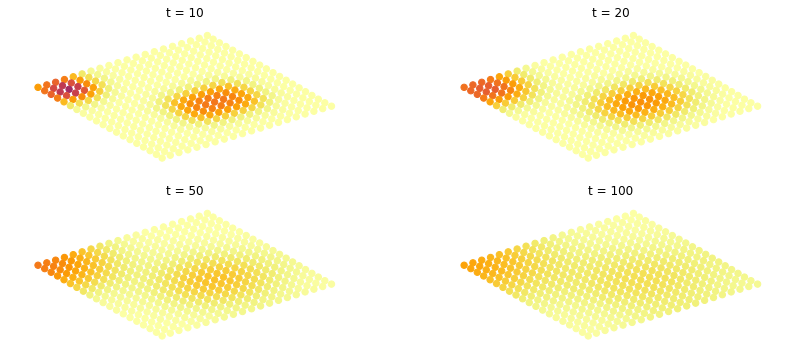

In [45]:
plt.figure(figsize=(7*2, 3*2))
i = 1
for t in [10, 20, 50, 100]:
    plt.subplot(2, 2, i)
    gridG = nx.grid_graph((20, 20))
    nx.draw_kamada_kawai(
        gridG,
        cmap=plt.cm.inferno_r,
        vmin=0, vmax=3,
        width=0,
        node_size=40,
        node_color=phi_t(A, phi0, C, t))
    plt.title('t = {}'.format(t))
    i += 1

Task 5. SIS model on networks (0 points)

Давайте рассмотрим модели эпидемий в сетях. Модель SIS описывается динамической формой 
Чтобы моделировать эпидемии в сетях, нам необходимо использовать вероятностный подход. Сначала давайте определим функцию, которая дает нам случайную выборку доступных узлов с заданной вероятностью.

Вот функция select_nodes, которая принимает np.array vec, где i-й элемент - это число соседей, которые могут повлиять на i-й узел с вероятностью proba. Например, vec может представлять количество зараженных соседей, скажем [0, 2, 1], а затем вероятность - это уровень заражения. Это означает, что у первого узла нет зараженных соседей, у второго есть два зараженных соседа, у третьего есть один зараженный сосед. Таким образом, второй узел  имеет вероятность заражения.

In [46]:
def select_nodes(vec, proba):
    sample = np.random.rand(len(vec))
    res = sample < (1 - (1 - proba)**vec)
    return res.astype('int')

Давайте заразим несколько случайных узлов и смоделируем распространение эпидемии.

Напишите функцию sis_networks, которая принимает график G, np.массив с начальным индикаторным вектором S, где S[i] равно 1, если i-й узел восприимчив, и 0 в противном случае (то же самое для I). Любой узел должен быть восприимчив или заражен на любом этапе. Также функция принимает значения бета, гамма, количество шагов k. Функция возвращает np.массив формы (k+1, 2, n), где n - количество узлов. На i-м шаге результат матрицы result[i, :, :] содержит показатель S в первом столбце и I во втором.

Подсказка: чтобы подсчитать количество зараженных соседей, используйте I @ A * S

In [47]:
def sis_networks(G, S, I, beta, gamma, k):
    # YOUR CODE HERE
    A = nx.to_numpy_array(G) #Возвращает матрицу смежности графа в виде массива NumPy.
    epidemic = []
    epidemic.append([S, I])
    for _ in range(k):
        dI = select_nodes(I @ A * S, beta) - select_nodes(I, gamma)
        I = I + dI
        S = 1 - I
        epidemic.append([S, I])
    return np.array(epidemic)

In [48]:
G = nx.barabasi_albert_graph(50, 3, seed=0)

I = np.zeros(len(G))
I[:3] = 1
S = 1 - I
beta = 0.2
gamma = 0.2

epidemic = sis_networks(G, S, I, beta, gamma, 100)
assert epidemic.sum() == 5050
assert epidemic.shape == (101, 2, 50)
assert (epidemic.sum(axis=1) == 1).sum() == 5050
sigma = 6.3853
mean = 16.0198
assert mean - 2*sigma < round(epidemic.sum(axis=2)[:, 0].mean(), 4) < mean + 2*sigma
sigma = 5.953
mean = 34.2178
assert mean - 2*sigma < round(epidemic.sum(axis=2)[:, 1].mean(), 4) < mean + 2*sigma

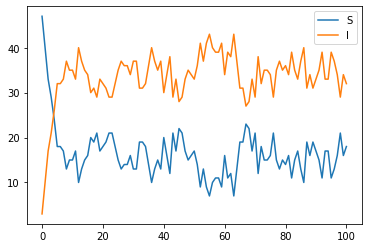

In [49]:
plt.plot(epidemic.sum(axis=2))
plt.legend(['S', 'I']);

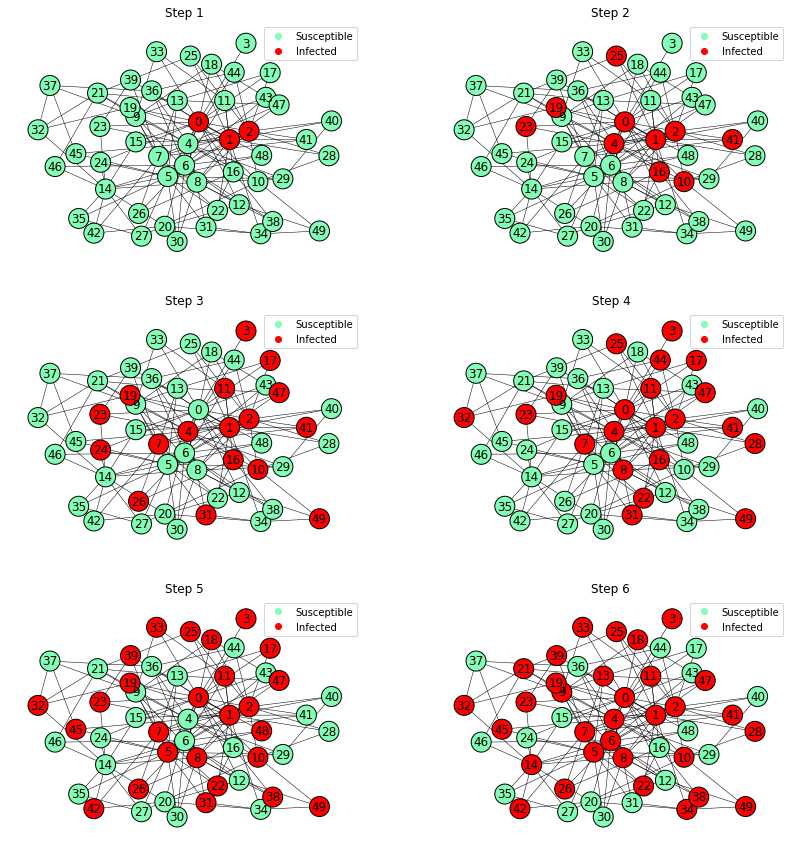

In [50]:
plt.figure(figsize=(7*2, 5*3))
pos = nx.kamada_kawai_layout(G)
i = 1
for S, I in epidemic[:6]:
    plt.subplot(3, 2, i)
    nodes = nx.draw_networkx_nodes(G, pos, 
            node_size=400,
            node_color=I+1, 
            vmin=0, vmax=2, 
            cmap=plt.cm.rainbow,
            edgecolors='black')
    nx.draw_networkx_edges(G, pos,
            width=0.5,
            node_size=400)
    nx.draw_networkx_labels(G, pos)
    plt.title('Step {}'.format(i))
    plt.legend(nodes.legend_elements()[0], ['Susceptible', 'Infected'])
    plt.axis('off')
    i += 1

Task 6. SIRS model on networks (2 points)

Давайте реализуем модель уровня узла SIRS 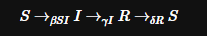
Напишите функцию sirs_networks, которая принимает график G, np.массив с начальным показателем S, где S[i] равно 1, если i-й узел восприимчив, и 0 в противном случае (то же самое для I и R). Также функция принимает значения бета, гамма, дельта, количество шагов k. Функция возвращает np.массив формы (k+1, 3, n), где n - количество узлов. На i-м шаге результат матрицы result[i, :, :] содержит показатель S в первом столбце, I во втором, R в третьем.


In [51]:
def sirs_networks(G, S, I, R, beta, gamma, delta, k):
    # YOUR CODE HERE
    A = nx.to_numpy_array(G)
    epidemic = []
    s = S.copy()
    i = I.copy()
    r = R.copy()
    epidemic.append([s.copy(), i.copy(), r.copy()])
    for _ in range(k):
        i_r = select_nodes(i, gamma)
        s_i = select_nodes(i @ A * s, beta)
        r_s = select_nodes(r, delta)
        di = s_i - i_r
        dr = i_r - r_s
        i += di
        r += dr
        s = 1 - i - r
        epidemic.append([s.copy(),i.copy(),r.copy()])
    return np.array(epidemic)

In [52]:
G = nx.barabasi_albert_graph(40, 3, seed=0)
I = np.zeros(len(G))
I[:3] = 1
S = 1 - I
R = np.zeros(len(G))

beta = 0.1
gamma = 0.3
delta = 0.1

epidemic = sirs_networks(G, S, I, R, beta, gamma, delta, 200)
assert epidemic.shape == (201, 3, 40)
assert (epidemic.sum(axis=1) == 1).sum() == 8040
assert (epidemic[200].sum(axis=1) == [40, 0, 0]).sum() == 3

for k in range(6):
    for node in G.nodes:
        if epidemic[k, 0, node] > epidemic[k+1, 0, node]:
            assert epidemic[k+1, 1, node] == 1
            neighbors = np.array([n for n in G.neighbors(node)])
            assert epidemic[k, 1][neighbors].sum()
        elif epidemic[k, 1, node] > epidemic[k+1, 1, node]:
            assert epidemic[k+1, 2, node] == 1
        elif epidemic[k, 2, node] > epidemic[k+1, 2, node]:
            assert epidemic[k+1, 0, node] == 1

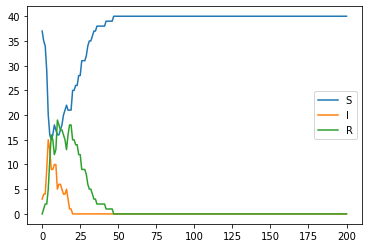

In [53]:
plt.plot(epidemic.sum(axis=2))
plt.legend(['S', 'I', 'R']);

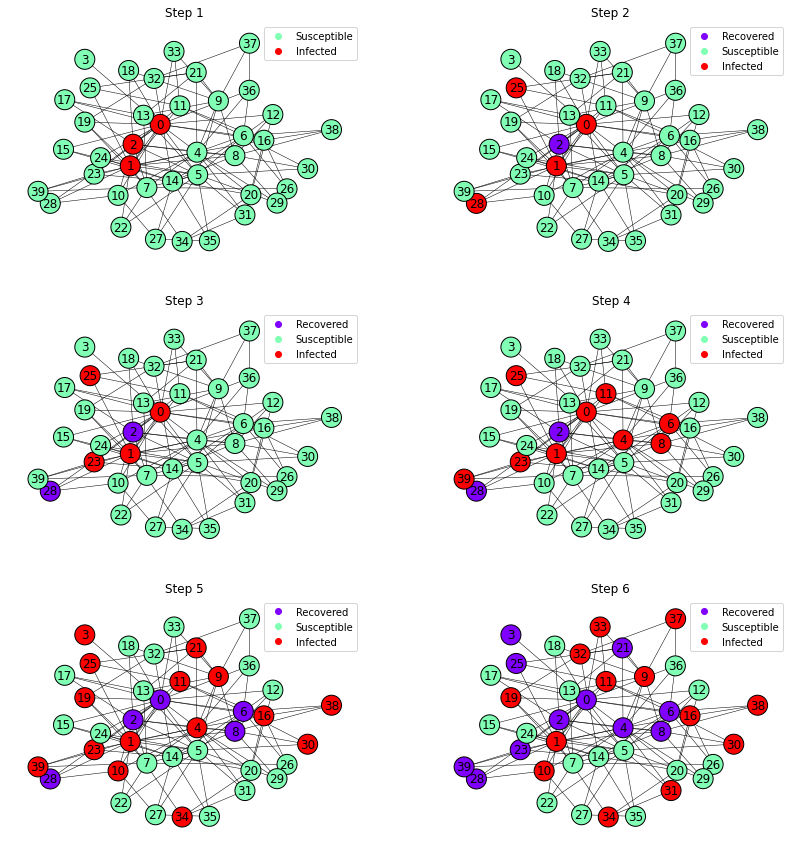

In [54]:
plt.figure(figsize=(7*2, 5*3))
pos = nx.kamada_kawai_layout(G)
i = 1
for S, I, R in epidemic[:6]:
    plt.subplot(3, 2, i)
    nodes = nx.draw_networkx_nodes(G, pos, 
            node_size=400,
            node_color=(S + I*2), 
            vmin=0, vmax=2, 
            cmap=plt.cm.rainbow,
            edgecolors='black')
    nx.draw_networkx_edges(G, pos,
            width=0.5,
            node_size=400)
    nx.draw_networkx_labels(G, pos)
    plt.title('Step {}'.format(i))
    if len(nodes.legend_elements()[0]) == 2:
        plt.legend(
            nodes.legend_elements()[0], 
            ['Susceptible', 'Infected'])
    else:
        plt.legend(
            nodes.legend_elements()[0], 
            ['Recovered', 'Susceptible', 'Infected'])
    plt.axis('off')
    i += 1

Мы также можем смоделировать "вторые волны", используя параметр delta


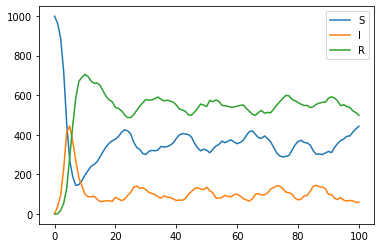

In [55]:
G = nx.barabasi_albert_graph(1000, 3, seed=0)

I = np.zeros(len(G))
I[0] = 1
S = 1 - I
R = np.zeros(len(G))

epidemic = sirs_networks(G, S, I, R, 0.3, 0.4, 0.07, 100)
plt.plot(epidemic.sum(axis=2))
plt.legend(['S', 'I', 'R']);

Граф Эрдоса-Реньи

Эта часть задания посвящена моделям распространения влияния: линейной пороговой модели и независимой каскадной модели. Существует множество применений этих типов моделей, например:

1)Рост политического движения в нестабильном обществе

2)Эффект “сарафанного радио”: когда у нас есть доступ к обильной информации, например, когда мы оцениваем новые технологии, рискованные финансовые активы или кандидатов на работу, нам часто не хватает способности разобраться в этом; следовательно, мы полагаемся на советы доверенных друзей, коллег или советников

3)“Вирусный маркетинг” влияет на успех новых продуктов

4)Внедрение медицинских и сельскохозяйственных инноваций

5)Каскадные сбои в энергосистемах

6)Принятие решения большинством голосов

Давайте рассмотрим эти модели на ориентированном графе Эрдеша-Реньи.

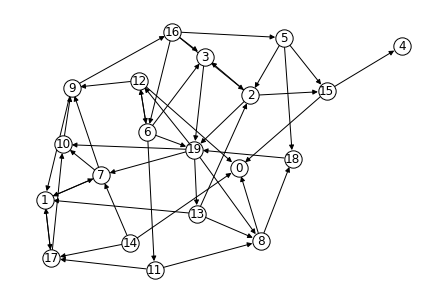

In [56]:
n = 20
G = nx.erdos_renyi_graph(n, 0.11, 0, True)

plt.figure(figsize=(6, 4))
pos = nx.kamada_kawai_layout(G)
nx.draw(G, pos, with_labels=True, node_color='white', edgecolors='black')

Задача 7. Линейная пороговая модель (0 points)

Линейная пороговая модель определяется следующим образом. Учитывая выбор пороговых значений для всех узлов и начального набора активных узлов, процесс распространения разворачивается детерминированно в дискретных шагах: на шаге t все узлы, которые были активны на шаге t-1, остаются активными; более того, каждый неактивный в данный момент узел становится активным тогда и только тогда, когда общая доля его активных соседей равна наименьший порог узла.

Напишите функцию linear_threshold, которая принимает график, np.массив active_nodes с нулями и единицами (если active_nodes[i] равно 1, то i-й узел активен), np.массив пороговых значений. Функция распространяет влияние и останавливается, когда модель перестает меняться. Функция возвращает np.array с активными узлами на каждом шаге. Первый шаг - это начальная активация, последний и предпоследний шаги одинаковы (мы хотим видеть, что распространение перестает меняться).

In [57]:
def linear_threshold(G, active_nodes, thresholds):
    # YOUR CODE HERE
    result =[active_nodes]
    current_active_nodes = active_nodes.copy()
    while True:
        active_nodes = current_active_nodes.copy()
        for n in G.nodes:
            if current_active_nodes[n] != 1:
                neighbors = [i for i in G.predecessors(n)]
                np.seterr(invalid='ignore')
                if  np.sum(active_nodes[neighbors])/len(neighbors) >= thresholds[n]:
                    current_active_nodes[n] = 1
        result.append(current_active_nodes.copy())
        if np.all(active_nodes == current_active_nodes):
            break
    return np.array(result)

In [58]:
np.random.seed(5)
active_nodes = np.zeros(n, 'int')
active_nodes[np.random.choice(np.arange(n), 2, False)] = 1
thresholds = np.random.uniform(0.5, 1, n)

sim = linear_threshold(G, active_nodes, thresholds)

assert sim.shape == (4, 20)
assert np.all(sim[0] == active_nodes)
assert np.all(sim[-1] == sim[-2])
assert sim[0, 4] == 0
assert sim[2, 4] == 1
assert sim[0, 3] == 0
assert sim[1, 15] == 1

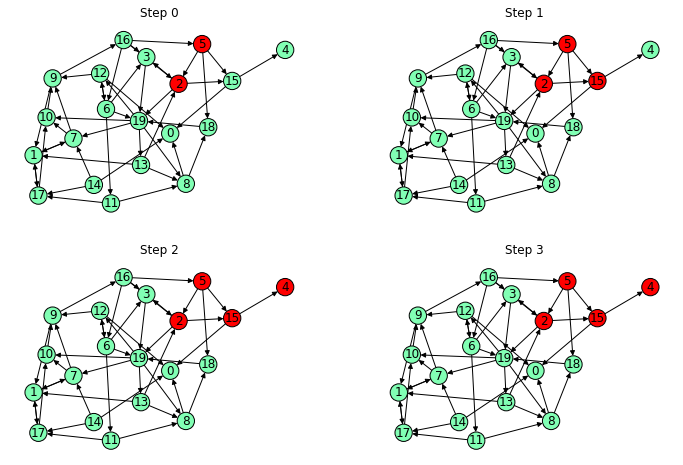

In [59]:
plt.figure(figsize=(6*2, 4*2))

for i, color in enumerate(sim):
    plt.subplot(2, 2, i+1)
    nx.draw(G, pos, with_labels=True, 
            node_color=color+1, 
            vmin=0, vmax=2, 
            cmap=plt.cm.rainbow,
            edgecolors='black')
    plt.title('Step {}'.format(i))
plt.show()

Задача 8. Независимая каскадная модель (2 points)

Следующий тип - независимая каскадная модель. Мы снова начинаем с начального набора активных узлов, и процесс разворачивается дискретными шагами в соответствии со следующим рандомизированным правилом. Когда узел u впервые становится активным на шаге t, ему предоставляется единственный шанс активировать каждого неактивного в данный момент соседа w; это удается с вероятностью  — параметром системы — независимо от истории на данный момент. (Если w имеет несколько вновь активированных соседей, их попытки упорядочиваются в произвольном порядке.) Если u это удастся, то w он станет активным на шаге t + 1; но независимо от того, удастся это или нет, он не может предпринимать никаких дальнейших попыток активировать w на последующих шагах.

Напишите функцию independent_cascade, которая принимает график, np.массив active_nodes с нулями и единицами (если active_nodes[i] равно 1, то i-й узел активен), np.массив с вероятностями распространения prop_proba для ребер, упорядоченных по G.ребра. Функция распространяет влияние и останавливается, когда модель перестает меняться. Функция возвращает np.array с активными узлами на каждом шаге. Первый шаг - это начальная активация, последний и предпоследний шаги одинаковы (мы хотим видеть, что модель перестает меняться).

In [60]:
import math
def independent_cascade(G, active_nodes, prop_proba):
    # YOUR CODE HERE
    for idx, edge in enumerate(G.edges):
        G[edge[0]][edge[1]]['prop'] = prop_proba[idx]
        G[edge[0]][edge[1]]['attempt'] = True
    result =[active_nodes]
    current_active_nodes = active_nodes.copy()
    while True:
        active_nodes = current_active_nodes.copy()
        for n in G.nodes:
            if current_active_nodes[n] == 1:
                for edge in G.edges(n):
                    if G[edge[0]][edge[1]]['attempt']:
                        G[edge[0]][edge[1]]['attempt'] = False
                        prop = G[edge[0]][edge[1]]['prop']
                        if np.random.rand() < prop:
                            current_active_nodes[edge[1]] = 1
        result.append(current_active_nodes.copy())
        if np.all(active_nodes == current_active_nodes):
            break
    return np.array(result)

In [61]:
np.random.seed(1)
active_nodes = np.zeros(20, 'int')
active_nodes[np.random.choice(np.arange(20), 2, False)] = 1
prop_proba = np.random.rand(len(G.edges))

sims = []
n_steps = []
for i in range(1000):
    sim = independent_cascade(G, active_nodes, prop_proba)
    sims.append(sim)
    n_steps.append(len(sim))
sigma = 1.9165
mean = 5.103
assert mean - 2*sigma < np.mean(n_steps) < mean + 2*sigma
sim = sims[n_steps.index(6)]
assert sim.shape == (6, 20)
assert np.all(sim[0] == active_nodes)
assert np.all(sim[-1] == sim[-2])
for i in range(1, 4):
    attempts = sim[i] - sim[i-1]
    new_active = sim[i+1] - sim[i]
    has_edge = False
    for j in np.argwhere(attempts == 1):
        for k in np.argwhere(new_active == 1):
            if G.has_edge(j[0], k[0]):
                has_edge = True
    assert has_edge

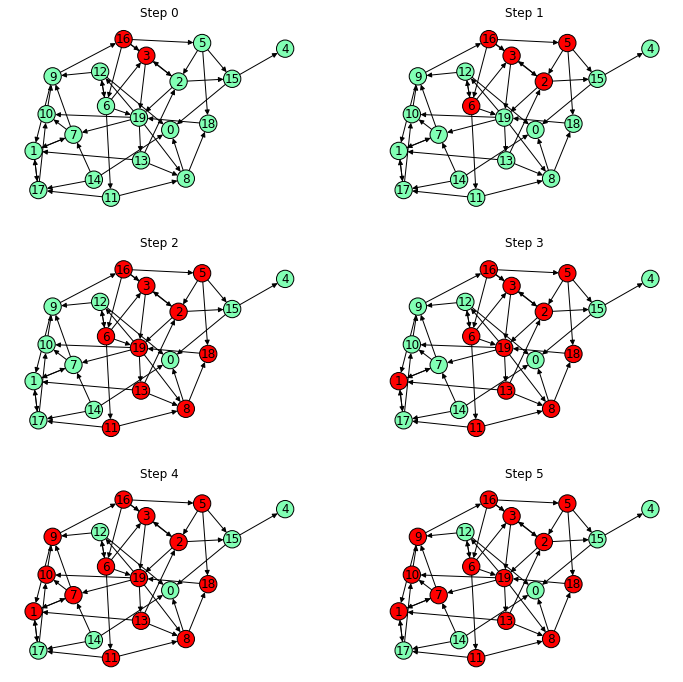

In [62]:
plt.figure(figsize=(6*2, 4*3))

for i, color in enumerate(sim):
    plt.subplot(3, 2, i+1)
    nx.draw(G, pos, with_labels=True, 
            node_color=color+1, 
            vmin=0, vmax=2, 
            cmap=plt.cm.rainbow,
            edgecolors='black')
    plt.title('Step {}'.format(i))
plt.show()

Задача 9. Жадная максимизация влияния (2 points)

Влияние - это ожидаемое количество активных узлов в конце процесса 
где  - начальные активные узлы и  - активные узлы в конце. Линейная пороговая модель является детерминированной, а затем 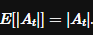

Задача максимизации влияния требует для заданного числа начальных активных узлов k найти набор узлов, который оказывает максимальное влияние. Это NP-трудная задача, но полезным свойством является то, что она может быть решена за полиномиальное время путем жадной оптимизации с гарантированной производительностью чуть выше 63%. Доказательства здесь. Алгоритм таков:
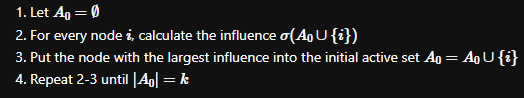

Напишите функцию greedy_influence_max, которая принимает график, пороговые значения линейной пороговой модели, количество активных узлов k и вычисляет начальные активные узлы с помощью жадного алгоритма. Функция возвращает np.array с нулями и единицами (если active_nodes[i] равно 1, то i-й узел активен).

In [63]:
def greedy_influence_max(G, thresholds, k):
    # YOUR CODE HERE
    active_nodes = np.zeros(np.size(G.nodes))
    while np.sum(active_nodes) < k:
        best_node = -1
        best_score = 0
        for v in G.nodes():
            if not active_nodes[v]:
                curr_active_nodes = active_nodes.copy()
                curr_active_nodes[v] = 1
                sigma = np.sum(linear_threshold(G, curr_active_nodes, thresholds)[-1])
                if sigma > best_score:
                    best_score = sigma
                    best_node = v
        active_nodes[best_node] = 1
    return active_nodes

In [64]:
n = 100
G = nx.erdos_renyi_graph(n, 0.07, 0, True)

np.random.seed(0)
active_nodes = np.zeros(n, 'int')
active_nodes[np.random.choice(np.arange(n), 2, False)] = 1
thresholds = np.random.uniform(0.1, 0.8, n)

best_active = greedy_influence_max(G, thresholds, 2)
assert best_active.shape == (100,)
assert best_active.sum() == 2
sim = linear_threshold(G, best_active, thresholds)
assert sim[-1].sum() > 21 * 0.63

Здесь та же модель, что и в задаче линейного порога, но с лучшим начальным активным набором.

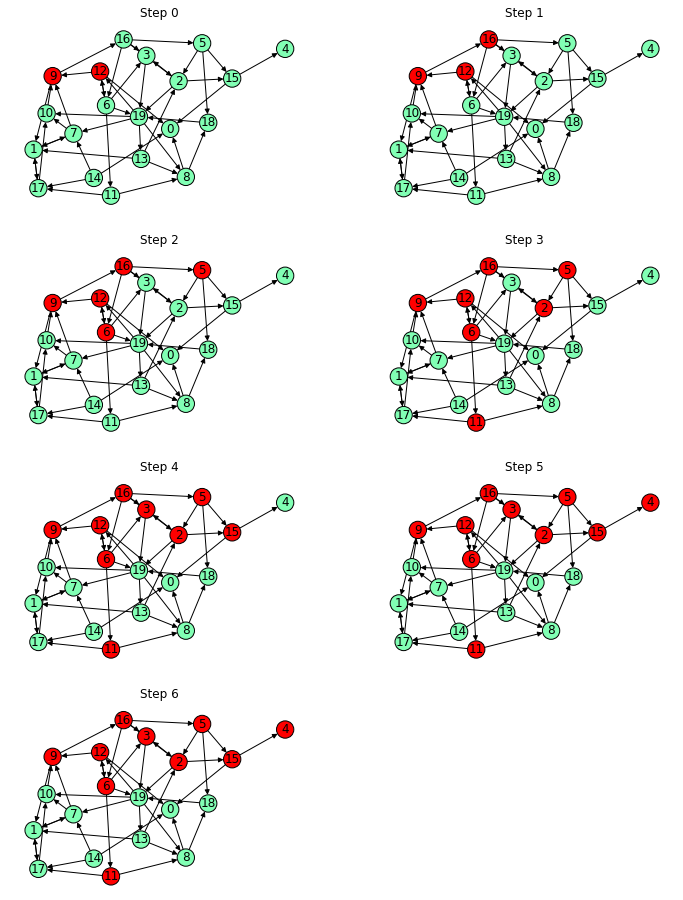

In [65]:
n = 20
G = nx.erdos_renyi_graph(n, 0.11, 0, True)

np.random.seed(5)
active_nodes = np.zeros(n, 'int')
active_nodes[np.random.choice(np.arange(n), 2, False)] = 1
thresholds = np.random.uniform(0.5, 1, n)

best_active = greedy_influence_max(G, thresholds, 2)
sim = linear_threshold(G, best_active, thresholds)

plt.figure(figsize=(6*2, 4*4))

for i, color in enumerate(sim):
    plt.subplot(4, 2, i+1)
    nx.draw(G, pos, with_labels=True, 
            node_color=color+1, 
            vmin=0, vmax=2, 
            cmap=plt.cm.rainbow,
            edgecolors='black')
    plt.title('Step {}'.format(i))
plt.show()